In [1]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import vice 
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["text.usetex"] = True 
mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" 
mpl.rcParams["errorbar.capsize"] = 5
mpl.rcParams["axes.linewidth"] = 2
mpl.rcParams["xtick.major.size"] = 16
mpl.rcParams["xtick.major.width"] = 2 
mpl.rcParams["xtick.minor.size"] = 8 
mpl.rcParams["xtick.minor.width"] = 1 
mpl.rcParams["ytick.major.size"] = 16
mpl.rcParams["ytick.major.width"] = 2 
mpl.rcParams["ytick.minor.size"] = 8 
mpl.rcParams["ytick.minor.width"] = 1 
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams["xtick.labelsize"] = 25
mpl.rcParams["ytick.labelsize"] = 25
mpl.rcParams["legend.fontsize"] = 25
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["ytick.right"] = True
mpl.rcParams["xtick.top"] = True
mpl.rcParams["xtick.minor.visible"] = True
mpl.rcParams["ytick.minor.visible"] = True

/Users/astrobeard/.local/lib/python3.7/site-packages/vice-1.3.0-py3.7-macosx-10.9-x86_64.egg/vice/__init__.py:136: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


This cell just reads in the data from the file Emily sent me and stores it globally. 

In [2]:
raw = np.genfromtxt("james_data.csv", delimiter = ',') 
data = {
    "id": [row[0] for row in raw], 
    "fe": [row[1] for row in raw], 
    "mg": [row[2] for row in raw], 
    "ba": [row[3] for row in raw], 
    "y": [row[4] for row in raw] 
} 

This cell sets up a row of three subplots with [Fe/Mg], [Ba/Mg], and [Y/Mg] on the y-axes and [Mg/H] on all three x-axes. The x- and y-axis limits are the same on all three panels. 

In [3]:
def setup_axes(): 
    fig = plt.figure(figsize = (21, 7), facecolor = "white") 
    xlabel = "[Mg/H]" 
    ylabels = ["[Fe/Mg]", "[Ba/Mg]", "[Y/Mg]"] 
    xlim = [-0.5, 0.5] 
    ylim = [-0.5, 0.5] 
    axes = [] 
    for i in range(3): 
        axes.append(fig.add_subplot(131 + i)) 
        axes[i].set_xlabel(xlabel) 
        axes[i].set_ylabel(ylabels[i]) 
        axes[i].set_xlim(xlim) 
        axes[i].set_ylim(ylim) 
    return axes 

Plot the observed sample - this just takes the observed sample, computes the abundance ratios of, e.g., [Ba/Mg] given [Ba/H] and [Mg/H] from the file and plots them up. 

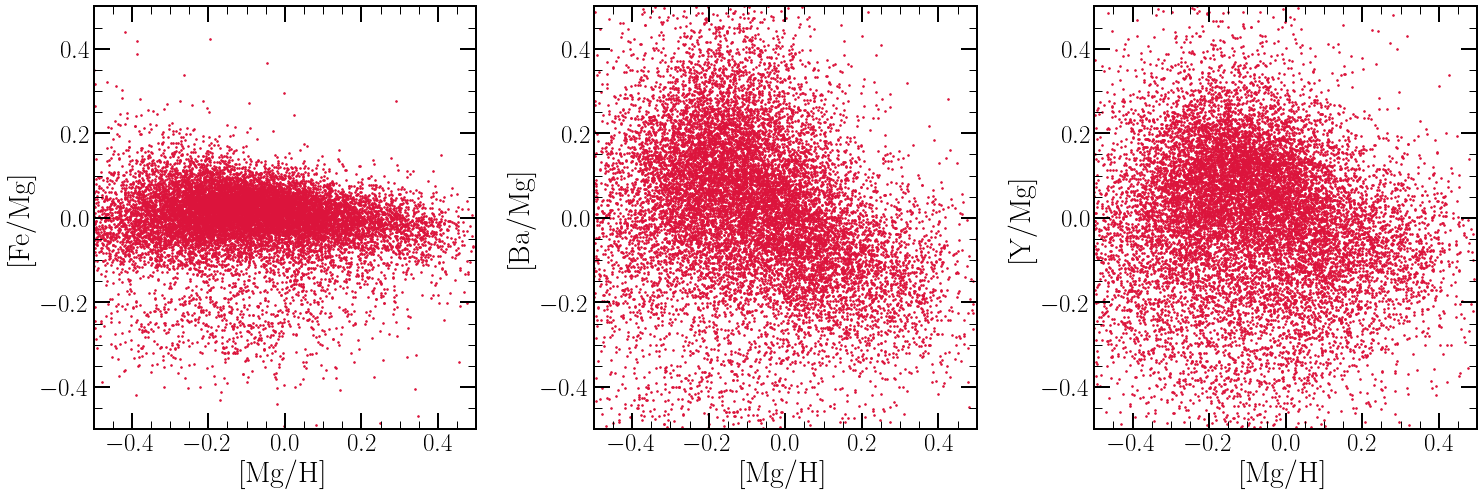

In [7]:
axes = setup_axes() 
    
def ratio(x, y): 
    # compute [X/Y] given the list of [X/H] and [Y/H] 
    return [a - b for a, b in zip(x, y)] 

kwargs = {
    "c": mpl.colors.get_named_colors_mapping()["crimson"], 
    "marker": ".", 
    "s": 10, 
    "rasterized": True 
}

axes[0].scatter(data["mg"], ratio(data["fe"], data["mg"]), **kwargs) 
axes[1].scatter(data["mg"], ratio(data["ba"], data["mg"]), **kwargs) 
axes[2].scatter(data["mg"], ratio(data["y"], data["mg"]), **kwargs) 

plt.tight_layout() 
plt.savefig("Emily_observed_sample.pdf") 
plt.show() 

Plot the mock data from the output. 

This cell first reads in the output using VICE, which requires only the relative path to the directory containing the output. When I ran this, it was in the parent directory at "Emily_mock.vice", so simply adjust the second line accordingly if it's name or relative path was different. 

Next, it filters down to stellar populations with Galactocentric radii between 5 and 12 kpc. I used 100-pc wide rings in this run, so the ring with an inner radius of 5 kpc is the 50th, and the one with an outer radius of 12 kpc is 119 (i.e. an inner radius of 11.9 kpc). I chose these bounds because they seemed like a reasonable guess at the radii at which these abundances would be well-measured in an APOGEE- or GALAH-like survey, but if they need to be changed, simply adjust the numbers in the call to ``out.stars.filter``. Be careful that for a detailed comparison, we should use the same radial and age ranges as the observed sample, so it's not likely that we can compare this plot directly to the one above. 

Then I'm randomly sampling 5000 single stars from the output. Since the output contains stellar populations and not single stars, the sampling algorithm needs to take into account the mass of each stellar population. I add up the masses simply because numpy requires the sum total of the sampling probabilities to equal 1, then calling ``numpy.random.choice`` tells me the index of each of the sampled stars from the output. 

After that, all that remains is actually scatter-plotting the points. 

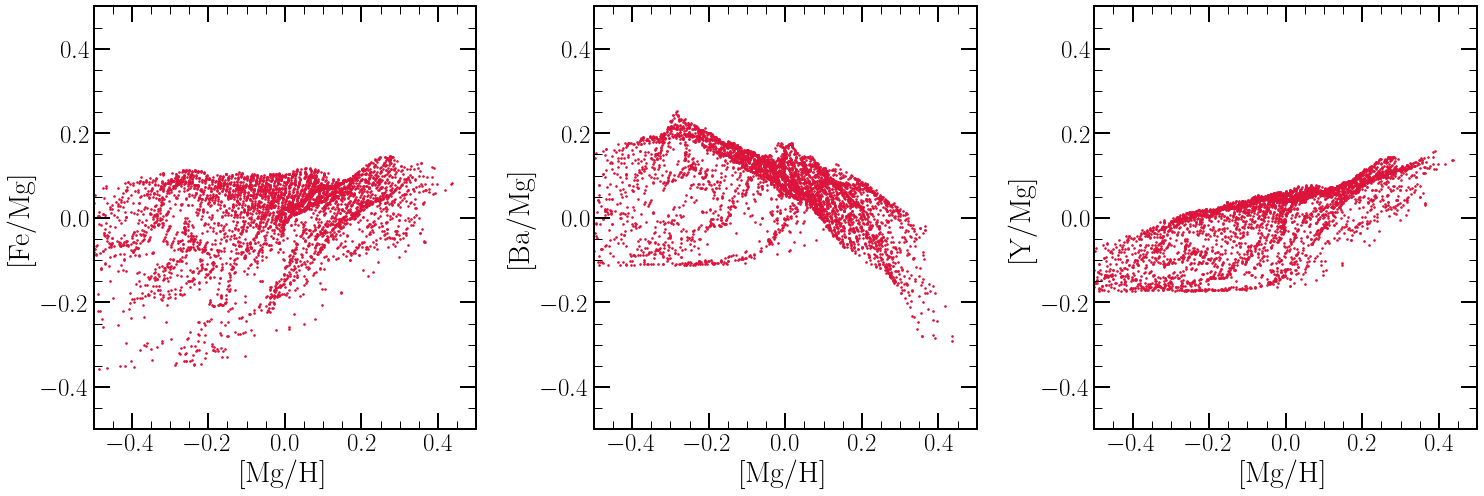

In [5]:
axes = setup_axes() 
out = vice.output("../Emily_mock") 
stars = out.stars.filter("zone_final", ">=", 50).filter("zone_final", "<=", 119) 
stellar_mass = sum(stars["mass"]) 
mass_fracs = [_ / stellar_mass for _ in stars["mass"]] 
indeces = np.random.choice(len(mass_fracs), size = 5000, p = mass_fracs) 

kwargs = {
    "c": mpl.colors.get_named_colors_mapping()["crimson"], 
    "marker": ".", 
    "s": 10, 
    "rasterized": True 
}

# filtered table has [mg/fe] recorded rather [fe/mg], conversion is trivial 
stars["[fe/mg]"] = [-i for i in stars["[mg/fe]"]] 
axes[0].scatter([stars["[mg/h]"][_] for _ in indeces], 
    [stars["[fe/mg]"][_] for _ in indeces], **kwargs) 
axes[1].scatter([stars["[mg/h]"][_] for _ in indeces], 
    [stars["[ba/mg]"][_] for _ in indeces], **kwargs) 
axes[2].scatter([stars["[mg/h]"][_] for _ in indeces], 
    [stars["[y/mg]"][_] for _ in indeces], **kwargs) 

plt.tight_layout() 
plt.savefig("Emily_mock_sample.pdf") 
plt.show() 

To see what the gas is doing as a function of time, I've plotted the gas-phase tracks in [X/Mg]-[Mg/H] space for Fe, Ba, and Y. Each line starts at T = 0 and ends at T = 13.2 Gyr, and shows the abundances as a function of time within a given ring. 

The variables ``zones`` and ``labels`` correspond to the names of the rings as VICE sees them (i.e. there's a directory called ``Emily_mock.vice/zone40.vice`` storing the output for that ring) and their radii in physical units (technically the inner radius of each 100-pc ring). 

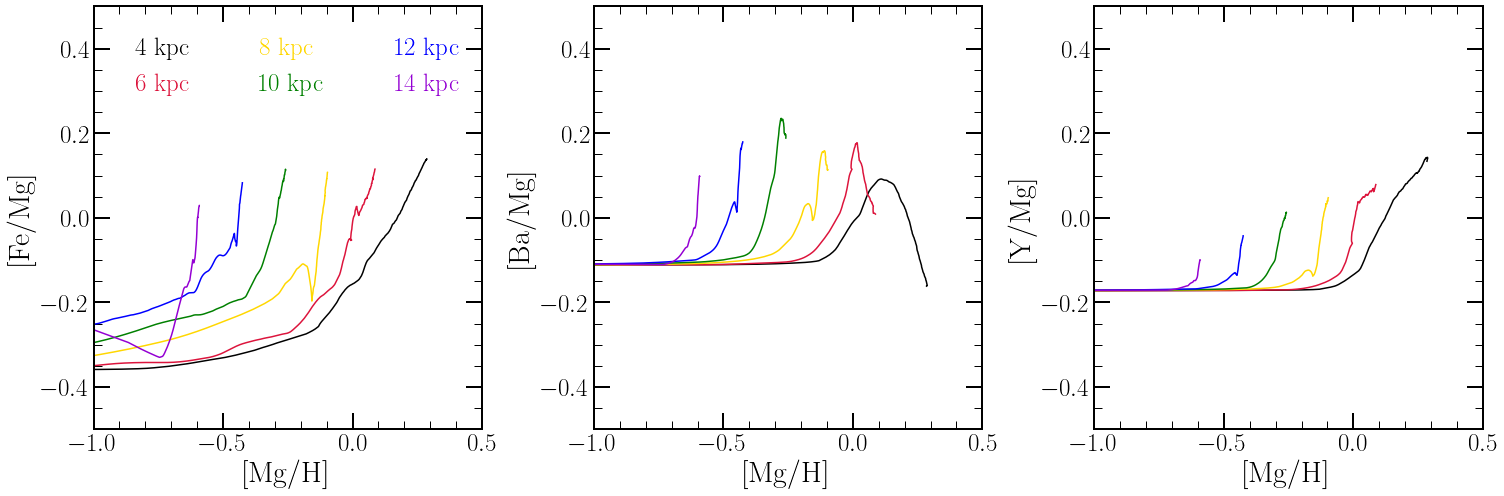

In [6]:
axes = setup_axes() 
for i in range(len(axes)): 
    axes[i].set_xlim([-1.0, 0.5]) 
out = vice.output("../Emily_mock") 

zones = ["zone40", "zone60", "zone80", "zone100", "zone120", "zone140"] 
labels = ["4 kpc", "6 kpc", "8 kpc", "10 kpc", "12 kpc", "14 kpc"] 
colors = ["black", "crimson", "gold", "green", "blue", "darkviolet"] 

for i in range(len(zones)): 
    kwargs = {
        "c": mpl.colors.get_named_colors_mapping()[colors[i]], 
        "label": labels[i] 
    } 
    
    # grabs the output for the corresponding ring, which you interact with exactly 
    # the same as if it were a one-zone model as opposed to inside of a multi-zone model 
    zone = out.zones[zones[i]] 
    axes[0].plot(zone.history["[mg/h]"], zone.history["[fe/mg]"], **kwargs) 
    axes[1].plot(zone.history["[mg/h]"], zone.history["[ba/mg]"], **kwargs) 
    axes[2].plot(zone.history["[mg/h]"], zone.history["[y/mg]"], **kwargs) 
    
leg = axes[0].legend(loc = 9, ncol = 3, frameon = False, handlelength = 0, 
    bbox_to_anchor = (0.5, 0.98)) 
for i in range(len(leg.legendHandles)): 
    leg.get_texts()[i].set_color(colors[i]) 
    leg.legendHandles[i].set_visible(False) 

plt.tight_layout() 
plt.savefig("Emily_mock_tracks.pdf") 
plt.show() 